In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
def split_image(image_pair):
    height, width_pair = image_pair.shape
    width = int(width_pair/2)

    image_left = image_pair[0:height, 0:width]
    image_right = image_pair[0:height, width:width_pair]
    
    return image_left, image_right, (width, height)

In [3]:
left_camera_npz = np.load('./calibration_data/camera_calibration_left.npz')
left_camera_matrix = left_camera_npz['camera_matrix']
left_dist_coeff = left_camera_npz['distortion_coeff']
print(left_camera_matrix)
print(left_dist_coeff)
        
stereo_npz = np.load('./calibration_data/stereo_camera_calibration.npz')
imageSize = tuple(stereo_npz['imageSize'])
left_map_1 = stereo_npz['left_map_1']
left_map_2 = stereo_npz['left_map_2']
right_map_1 = stereo_npz['right_map_1']
right_map_2 = stereo_npz['right_map_2']
R = stereo_npz['R']
T = stereo_npz['T']
E = stereo_npz['E']
F = stereo_npz['F']
Q = stereo_npz['Q']

print(R)
print(T)
print(Q)

[[316.01436172   0.         161.66186171]
 [  0.         317.54657941 124.93906503]
 [  0.           0.           1.        ]]
[[ 0.18527088  0.28762751  0.00769752  0.0032466  -2.99999472]]
[[ 0.99992412 -0.00980325 -0.00745973]
 [ 0.0097133   0.99988082 -0.01199953]
 [ 0.00757648  0.01192616  0.99990018]]
[[6.58757762]
 [0.03790865]
 [0.20747435]]
[[ 1.00000000e+00  0.00000000e+00  0.00000000e+00 -1.46209053e+02]
 [ 0.00000000e+00  1.00000000e+00  0.00000000e+00 -1.13640412e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.20602200e+02]
 [ 0.00000000e+00  0.00000000e+00 -1.51723127e-01  0.00000000e+00]]


In [4]:
image_filename = 'dm-tune.jpg'

image_pair = cv2.imread(image_filename, cv2.IMREAD_COLOR)
image_pair = cv2.cvtColor(image_pair,cv2.COLOR_BGR2GRAY)
image_left, image_right, (width, height) = split_image(image_pair)

rectified_image_left = cv2.remap(image_left, left_map_1, left_map_2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)
rectified_image_right = cv2.remap(image_right, right_map_1, right_map_2, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

In [5]:
autotune_min = 10000000
autotune_max = -10000000

def stereo_depth_map(image_left, image_right):
    num_disparities = 4*16
    block_size =15
    
    # Stereo BM matcher
    sbm = cv2.StereoBM_create(numDisparities=num_disparities, blockSize=block_size)
    sbm.setPreFilterType(1)
    sbm.setPreFilterSize(5)
    sbm.setPreFilterCap(41)
    sbm.setMinDisparity(0) #-25
    sbm.setNumDisparities(num_disparities)
    sbm.setTextureThreshold(100)
    sbm.setUniquenessRatio(9)
    sbm.setSpeckleRange(14)
    sbm.setSpeckleWindowSize(99)

    disparity = sbm.compute(image_left, image_right)
    
    local_max = disparity.max()
    local_min = disparity.min()
    
    # "Jumping colors" protection for depth map visualization
    global autotune_max, autotune_min
    autotune_max = max(autotune_max, disparity.max())
    autotune_min = min(autotune_min, disparity.min())

    disparity_grayscale = (disparity-autotune_min)*(65535.0/(autotune_max-autotune_min))
    disparity_fixtype = cv2.convertScaleAbs(disparity_grayscale, alpha=(255.0/65535.0))
    disparity_color = cv2.applyColorMap(disparity_fixtype, cv2.COLORMAP_JET)
    return disparity_color, disparity_fixtype, disparity.astype(np.float32) / 16.0

In [6]:
# Disparity map calculation
disparity, disparity_bw, native_disparity  = stereo_depth_map(rectified_image_left, rectified_image_right)
print(native_disparity.min())
print(native_disparity.max())

-1.0
62.0


<IPython.core.display.Javascript object>


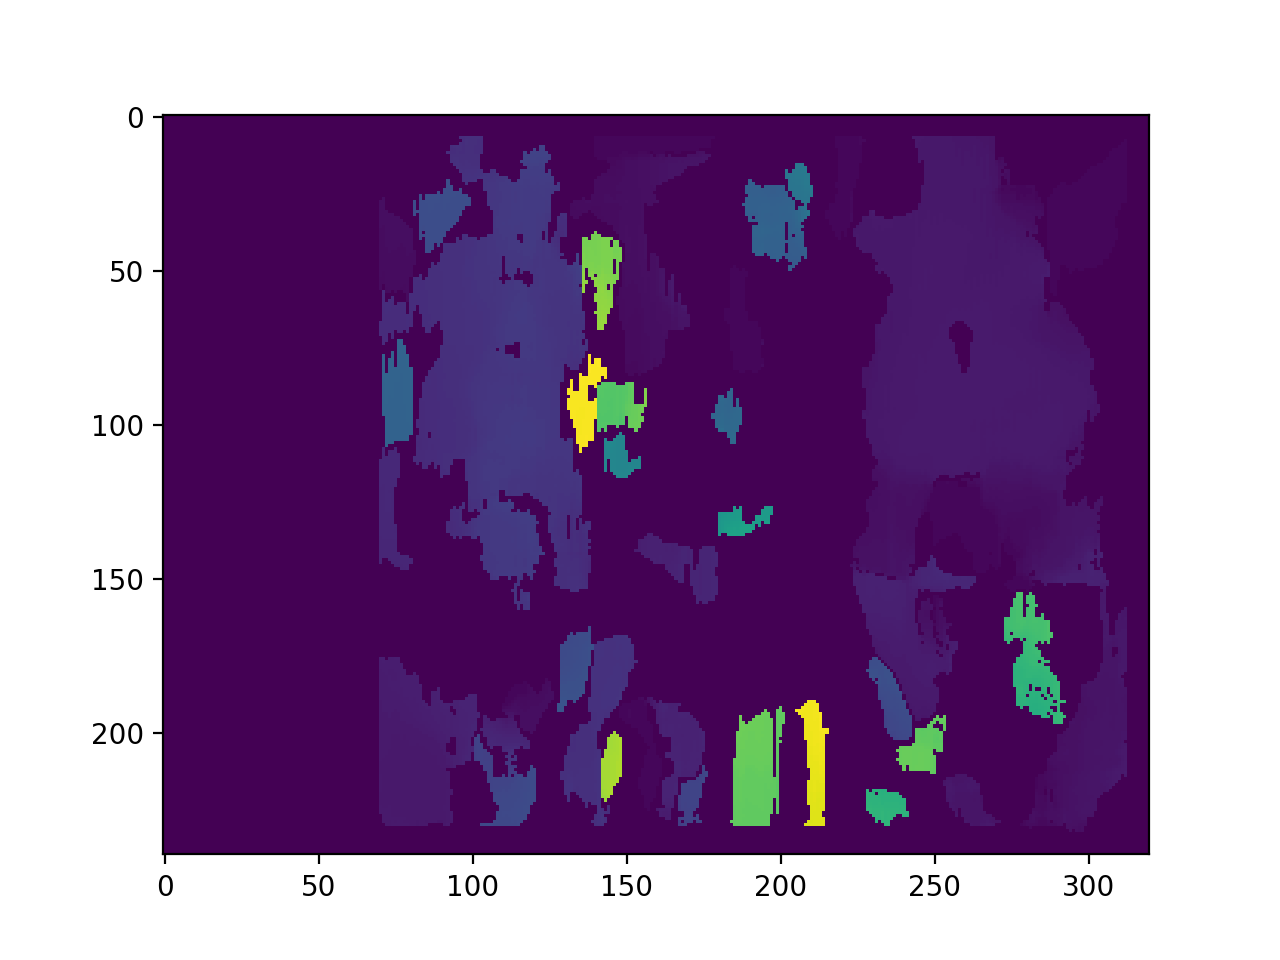

In [7]:
plt.imshow(native_disparity)

In [8]:
f = left_camera_matrix[0,0]
b = T[0]
print(f)
print(b)
safe_disparity = native_disparity
safe_disparity[safe_disparity == 0] = 0.1
safe_disparity[safe_disparity == -1] = 0.1

# Initialize the depth map to match the size of the disparity map
depth_map = np.ones(safe_disparity.shape, np.single)

# Calculate the depths 
depth_map[:] = f * b / safe_disparity[:]

316.0143617175832
[6.58757762]


In [9]:
_3dImage = cv2.reprojectImageTo3D(native_disparity, Q)

In [10]:
_3dImage[95:100,250:255,2]

array([[-593.1436, -593.1436, -593.1436, -593.1436, -593.1436],
       [-603.7355, -593.1436, -593.1436, -593.1436, -593.1436],
       [-603.7355, -593.1436, -593.1436, -593.1436, -593.1436],
       [-593.1436, -593.1436, -593.1436, -593.1436, -593.1436],
       [-593.1436, -593.1436, -593.1436, -593.1436, -593.1436]],
      dtype=float32)

In [11]:
depth_map[95:100,250:255] # 0.75 m

array([[584.35626, 584.35626, 584.35626, 584.35626, 584.35626],
       [594.7912 , 584.35626, 584.35626, 584.35626, 584.35626],
       [594.7912 , 584.35626, 584.35626, 584.35626, 584.35626],
       [584.35626, 584.35626, 584.35626, 584.35626, 584.35626],
       [584.35626, 584.35626, 584.35626, 584.35626, 584.35626]],
      dtype=float32)

In [12]:
_3dImage[95:100,95:100,2]

array([[-284.1108 , -281.7432 , -277.12448, -277.12448, -272.65472],
       [-284.1108 , -281.7432 , -279.41476, -277.12448, -274.87143],
       [-284.1108 , -281.7432 , -279.41476, -277.12448, -274.87143],
       [-284.1108 , -281.7432 , -279.41476, -279.41476, -277.12448],
       [-284.1108 , -281.7432 , -279.41476, -277.12448, -277.12448]],
      dtype=float32)

In [13]:
depth_map[95:100,95:100]

array([[279.90173, 277.5692 , 273.0189 , 273.0189 , 268.6154 ],
       [279.90173, 277.5692 , 275.27527, 273.0189 , 270.79922],
       [279.90173, 277.5692 , 275.27527, 273.0189 , 270.79922],
       [279.90173, 277.5692 , 275.27527, 275.27527, 273.0189 ],
       [279.90173, 277.5692 , 275.27527, 273.0189 , 273.0189 ]],
      dtype=float32)